# ML Baseline & Feature Engineering: Automated Movement Assessment
## 4DV652 - Data Intensive Systems

**Project:** Automated Movement Assessment (AIMO)  
**Task:** Develop baseline linear regression model and explore feature engineering techniques

### Context
This project develops a data-driven system to automatically assess human movement quality (Deep Squat exercise) based on:
- **Input:** 3D skeleton sequences from Kinect camera (40 features after preprocessing)
- **Output:** AimoScore (expert quality score 0-100)
- **Goal:** Train ML models to predict expert scores from movement features

### Key Insights from Domain Knowledge
- Features include **38 movement features** (angle deviations) + **2 time features**
- Some features may be **identical or highly correlated** (to be removed)
- **Left-right symmetry constraints** should be enforced (e.g., left vs right knee)
- Feature deviations are weighted by domain experts (larger deviation = worse movement)

### Dataset
- **Records:** 2095 deep squat assessments
- **Features:** 40 (38 movement angles + 2 timing)
- **Target:** AimoScore (continuous, 0-100)
- **Ground Truth:** Expert assessments from AIMO methodology

## Step 0: Setup & Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE, mutual_info_regression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 7)

print("✓ All imports successful")
print(f"✓ Numpy version: {np.__version__}")
print(f"✓ Pandas version: {pd.__version__}")

✓ All imports successful
✓ Numpy version: 2.2.6
✓ Pandas version: 2.3.3


## Step 1: Load and Explore Data

**What we're doing:**
- Loading the A2_dataset.csv with movement assessment data
- Exploring structure: 2095 records with 42 features
- Identifying AimoScore as target variable
- Checking for missing values and data quality

**What to expect:**
- Dataset shape: (2095, 42) or (2095, 43) depending on if target is included
- Target: AimoScore column (continuous values 0-100)
- 38 FMS/NASM angle features (large values = bad movement)
- 2 time-based features (timing deviations)
- Potentially some identical or highly correlated features
- No missing values expected

**Data-driven insights:**
- Understand feature distributions
- Identify potential outliers
- See which features correlate with quality assessment

In [4]:
# Load dataset
df = pd.read_csv('/Users/reemothman/Downloads/Data-intensive-systems/Datasets_all/A2_dataset_80.csv')  # Update path as needed

print("="*80)
print("DATASET EXPLORATION")
print("="*80)
print(f"\nDataset Shape: {df.shape}")
print(f"Records: {df.shape[0]}, Features: {df.shape[1]}")

print(f"\n{'First 5 rows:'}")
print(df.head())

print(f"\n{'Column names:'}")
print(df.columns.tolist())

print(f"\n{'Data types:'}")
print(df.dtypes)

print(f"\n{'Missing values:'}")
missing = df.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
else:
    print("✓ No missing values found")

print(f"\n{'Basic Statistics:'}")
print(df.describe())

DATASET EXPLORATION

Dataset Shape: (1675, 42)
Records: 1675, Features: 42

First 5 rows:
   AimoScore  No_1_Angle_Deviation  No_2_Angle_Deviation  \
0   0.653711              0.361071              0.561932   
1   0.866667              0.279770              0.868006   
2   0.900765              0.279770              0.103778   
3   0.972904              0.279770              0.626016   
4   0.721837              0.279770              0.092300   

   No_3_Angle_Deviation  No_4_Angle_Deviation  No_5_Angle_Deviation  \
0              0.346724              0.337159              0.259684   
1              0.346724              0.188905              0.331899   
2              0.346724              0.225729              0.523673   
3              0.512195              0.188905              0.163080   
4              0.346724              0.634146              0.698231   

   No_6_Angle_Deviation  No_7_Angle_Deviation  No_8_Angle_Deviation  \
0              0.204687              0.194165      


Target Variable:
Column: AimoScore

Statistics:
count    1675.000000
mean        0.575319
std         0.237320
min         0.010000
25%         0.409259
50%         0.623084
75%         0.761946
max         0.993987
Name: AimoScore, dtype: float64


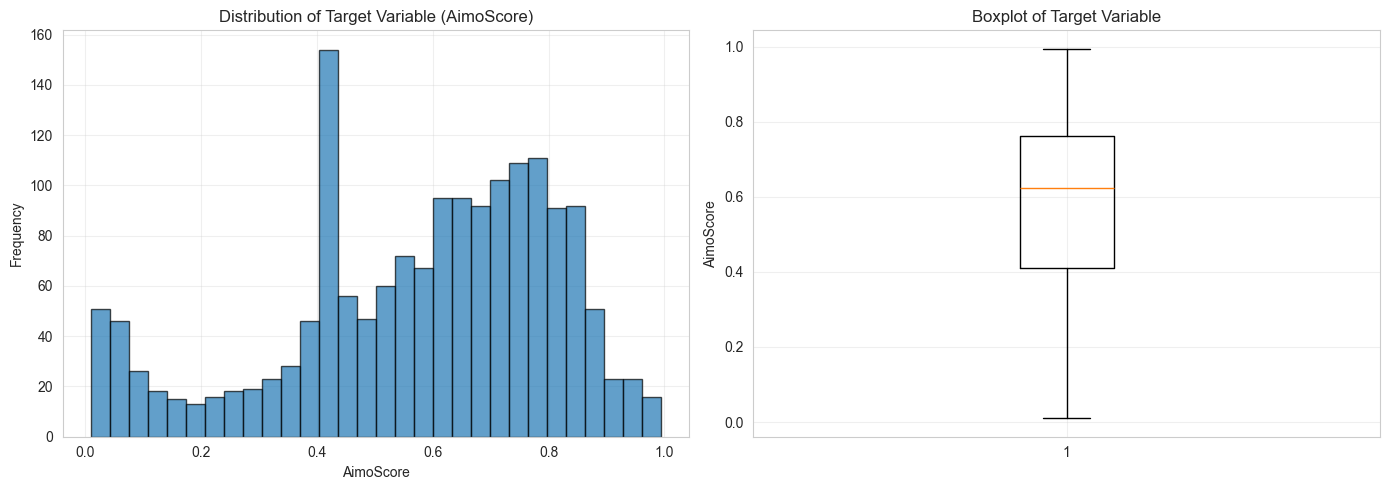


Target statistics:
  Min: 0.01
  Max: 0.99
  Mean: 0.58
  Std: 0.24
  Skewness: -0.6940


In [5]:
# Identify target variable and prepare data
# Check for AimoScore column
if 'AimoScore' in df.columns:
    target_col = 'AimoScore'
else:
    # If not found, it's likely the last column
    target_col = df.columns[-1]
    print(f"⚠ AimoScore not found, using last column: {target_col}")

print(f"\n{'Target Variable:'}")
print(f"Column: {target_col}")
print(f"\nStatistics:")
print(df[target_col].describe())

# Visualize target distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df[target_col], bins=30, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('AimoScore')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Target Variable (AimoScore)')
axes[0].grid(True, alpha=0.3)

axes[1].boxplot(df[target_col])
axes[1].set_ylabel('AimoScore')
axes[1].set_title('Boxplot of Target Variable')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nTarget statistics:")
print(f"  Min: {df[target_col].min():.2f}")
print(f"  Max: {df[target_col].max():.2f}")
print(f"  Mean: {df[target_col].mean():.2f}")
print(f"  Std: {df[target_col].std():.2f}")
print(f"  Skewness: {stats.skew(df[target_col]):.4f}")

## Step 2: Identify and Remove Duplicate/Identical Features

**What we're doing:**
- Finding features that are identical (same values across all rows)
- Finding features with extremely high correlation (>0.99)
- Removing duplicates to clean the feature space

**What to expect:**
- Discover 1-3 pairs of identical/nearly-identical features
- Feature count reduction (42 → 39-41)
- Clean dataset without redundant information
- Improved feature stability

**Domain context:**
- Some FMS features may duplicate NASM features (e.g., feature 5 = feature 14)
- Identical features provide no new information
- Highly correlated features increase multicollinearity

In [6]:
# Separate features from target
X = df.drop(target_col, axis=1)
y = df[target_col]

print(f"Original feature set: {X.shape[1]} features")

# Function to find duplicate features
def find_duplicate_features(X, threshold=0.99):
    """
    Find identical features (correlation = 1.0) and highly correlated features
    """
    correlation_matrix = X.corr().abs()
    duplicates = []
    identical = []
    
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            corr_val = correlation_matrix.iloc[i, j]
            col_i = correlation_matrix.columns[i]
            col_j = correlation_matrix.columns[j]
            
            if corr_val == 1.0:
                identical.append((col_i, col_j, corr_val))
            elif corr_val >= threshold:
                duplicates.append((col_i, col_j, corr_val))
    
    return identical, duplicates

print("\n" + "="*80)
print("DUPLICATE FEATURE DETECTION")
print("="*80)

identical, highly_corr = find_duplicate_features(X, threshold=0.99)

print(f"\nIdentical features (correlation = 1.0): {len(identical)}")
if identical:
    for col1, col2, corr in identical:
        print(f"  ✗ {col1} == {col2} (r={corr:.4f})")
else:
    print("  ✓ None found")

print(f"\nHighly correlated features (correlation > 0.99): {len(highly_corr)}")
if highly_corr:
    for col1, col2, corr in highly_corr:
        print(f"  ✗ {col1} <-> {col2} (r={corr:.4f})")
else:
    print("  ✓ None found")

# Identify columns to drop
cols_to_drop = set()
for col1, col2, _ in identical:
    cols_to_drop.add(col2)  # Keep first, drop second
for col1, col2, _ in highly_corr:
    cols_to_drop.add(col2)  # Keep first, drop second

print(f"\nFeatures to remove: {len(cols_to_drop)}")
if cols_to_drop:
    for col in cols_to_drop:
        print(f"  - {col}")

# Create clean dataset
X_clean = X.drop(columns=list(cols_to_drop))
print(f"\nCleaned feature set: {X_clean.shape[1]} features (removed {len(cols_to_drop)})")

df_clean = df.drop(columns=list(cols_to_drop))
print(f"✓ Clean dataset shape: {df_clean.shape}")

Original feature set: 41 features

DUPLICATE FEATURE DETECTION

Identical features (correlation = 1.0): 5
  ✗ No_1_Angle_Deviation == No_3_NASM_Deviation (r=1.0000)
  ✗ No_5_Angle_Deviation == No_1_NASM_Deviation (r=1.0000)
  ✗ No_7_Angle_Deviation == No_2_NASM_Deviation (r=1.0000)
  ✗ No_10_Angle_Deviation == No_4_NASM_Deviation (r=1.0000)
  ✗ No_13_Angle_Deviation == No_5_NASM_Deviation (r=1.0000)

Highly correlated features (correlation > 0.99): 0
  ✓ None found

Features to remove: 5
  - No_1_NASM_Deviation
  - No_3_NASM_Deviation
  - No_2_NASM_Deviation
  - No_5_NASM_Deviation
  - No_4_NASM_Deviation

Cleaned feature set: 36 features (removed 5)
✓ Clean dataset shape: (1675, 37)


## Step 3: Train Baseline Linear Regression Model

**What we're doing:**
- Split data into train (80%) and test (20%) sets
- Standardize all features (important for linear regression)
- Train linear regression using ALL clean features
- Evaluate on both train and test sets

**What to expect:**
- **Baseline R² score:** ~0.35-0.55 (typical for movement assessment)
- **Overfitting gap:** Train R² > Test R² (shows some overfitting with all features)
- RMSE & MAE metrics showing prediction error magnitude
- This becomes your **reference point** - all other models compared against this

**Why it matters:**
- Establishes the floor - "what's the simplest possible model?"
- If R² is low, feature engineering is critical
- If overfitting gap is large (>0.15), feature selection will help

In [7]:
# Prepare data for modeling
X_final = X_clean
y_final = y

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_final, test_size=0.2, random_state=42
)

print("="*80)
print("DATA SPLIT")
print("="*80)
print(f"Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X_final)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X_final)*100:.1f}%)")
print(f"Features: {X_train.shape[1]}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n✓ Features scaled using StandardScaler")
print(f"  Train mean: {X_train_scaled.mean():.4f}, std: {X_train_scaled.std():.4f}")
print(f"  Test mean: {X_test_scaled.mean():.4f}, std: {X_test_scaled.std():.4f}")

DATA SPLIT
Training set: 1340 samples (80.0%)
Test set: 335 samples (20.0%)
Features: 36

✓ Features scaled using StandardScaler
  Train mean: 0.0000, std: 1.0000
  Test mean: 0.0072, std: 1.0111


In [8]:
# Train baseline model (all features)
baseline_model = LinearRegression()
baseline_model.fit(X_train_scaled, y_train)

# Predictions
y_train_pred_baseline = baseline_model.predict(X_train_scaled)
y_test_pred_baseline = baseline_model.predict(X_test_scaled)

# Metrics
baseline_train_r2 = r2_score(y_train, y_train_pred_baseline)
baseline_test_r2 = r2_score(y_test, y_test_pred_baseline)
baseline_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_baseline))
baseline_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_baseline))
baseline_train_mae = mean_absolute_error(y_train, y_train_pred_baseline)
baseline_test_mae = mean_absolute_error(y_test, y_test_pred_baseline)
baseline_test_mape = mean_absolute_percentage_error(y_test, y_test_pred_baseline)

print("\n" + "="*80)
print("BASELINE MODEL - ALL FEATURES")
print("="*80)
print(f"\nTraining Performance:")
print(f"  R² Score:  {baseline_train_r2:.4f}")
print(f"  RMSE:      {baseline_train_rmse:.4f} (score points)")
print(f"  MAE:       {baseline_train_mae:.4f}")

print(f"\nTest Performance (EVALUATION METRIC):")
print(f"  R² Score:  {baseline_test_r2:.4f}  ← YOUR BENCHMARK")
print(f"  RMSE:      {baseline_test_rmse:.4f} (score points)")
print(f"  MAE:       {baseline_test_mae:.4f}")
print(f"  MAPE:      {baseline_test_mape:.4f}")

print(f"\nOverfitting Analysis:")
baseline_gap = baseline_train_r2 - baseline_test_r2
print(f"  Train R² - Test R² = {baseline_gap:.4f}")
if baseline_gap < 0.05:
    print(f"  ✓ Excellent generalization")
elif baseline_gap < 0.10:
    print(f"  ✓ Good generalization")
elif baseline_gap < 0.15:
    print(f"  ⚠ Moderate overfitting (feature selection may help)")
else:
    print(f"  ✗ Significant overfitting (feature selection recommended)")

print("\n" + "="*80)


BASELINE MODEL - ALL FEATURES

Training Performance:
  R² Score:  0.6156
  RMSE:      0.1491 (score points)
  MAE:       0.1143

Test Performance (EVALUATION METRIC):
  R² Score:  0.4864  ← YOUR BENCHMARK
  RMSE:      0.1601 (score points)
  MAE:       0.1222
  MAPE:      0.7753

Overfitting Analysis:
  Train R² - Test R² = 0.1293
  ⚠ Moderate overfitting (feature selection may help)



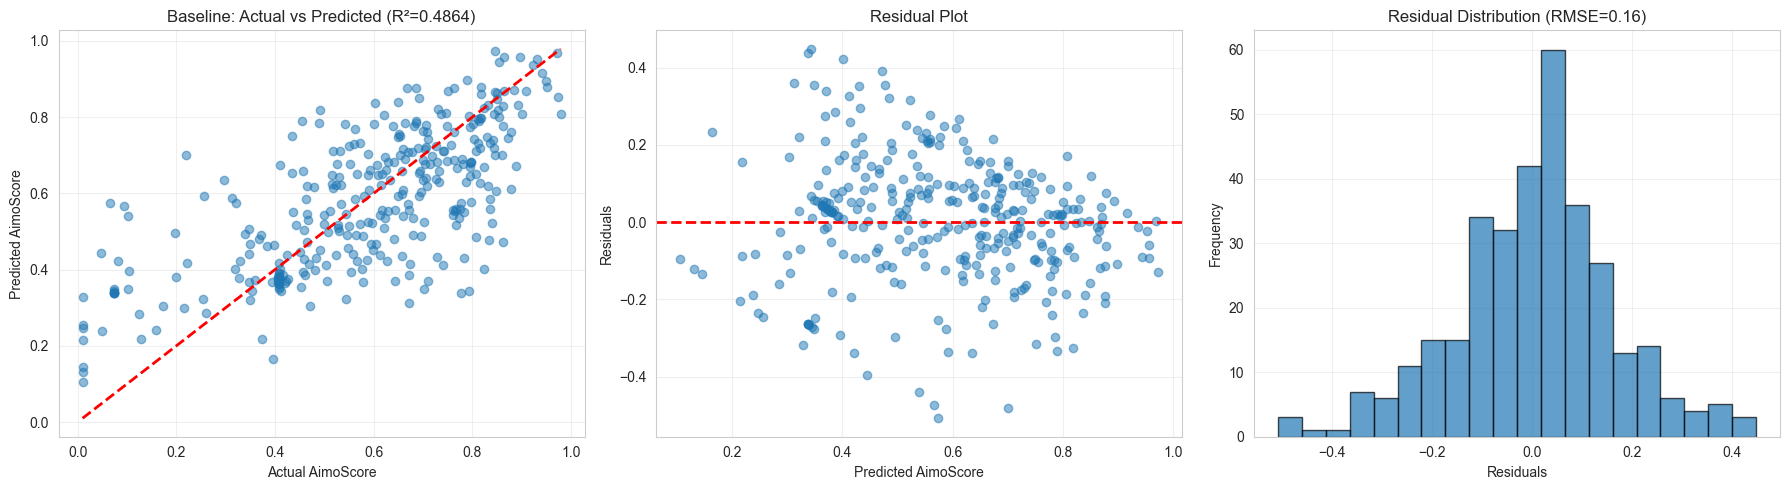

In [9]:
# Visualize baseline predictions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Actual vs Predicted
axes[0].scatter(y_test, y_test_pred_baseline, alpha=0.5)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual AimoScore')
axes[0].set_ylabel('Predicted AimoScore')
axes[0].set_title(f'Baseline: Actual vs Predicted (R²={baseline_test_r2:.4f})')
axes[0].grid(True, alpha=0.3)

# Residuals
residuals = y_test - y_test_pred_baseline
axes[1].scatter(y_test_pred_baseline, residuals, alpha=0.5)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted AimoScore')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Residual Plot')
axes[1].grid(True, alpha=0.3)

# Residual distribution
axes[2].hist(residuals, bins=20, edgecolor='black', alpha=0.7)
axes[2].set_xlabel('Residuals')
axes[2].set_ylabel('Frequency')
axes[2].set_title(f'Residual Distribution (RMSE={baseline_test_rmse:.2f})')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 4: Feature Selection - Correlation-Based

**What we're doing:**
- Computing correlation of each feature with target (AimoScore)
- Removing weak predictors (correlation < 0.05)
- Keeping only features with meaningful relationship to target

**What to expect:**
- Visualize top 15-20 features by correlation
- Remove 5-10 low-correlation features
- Test R² similar or slightly lower, but **better generalization** (smaller overfitting gap)
- Much simpler model, easier to interpret

**Domain insights:**
- High-weight FMS/NASM features should have high correlation
- Time features may have lower correlation
- Identifies which movement angles actually matter for scoring

CORRELATION-BASED FEATURE SELECTION

Top 20 features by absolute correlation with AimoScore:
EstimatedScore           0.571022
No_12_NASM_Deviation     0.489057
No_11_NASM_Deviation     0.473923
No_13_Angle_Deviation    0.418670
No_10_NASM_Deviation     0.408648
No_10_Angle_Deviation    0.379893
No_12_Angle_Deviation    0.332944
No_6_Angle_Deviation     0.318481
No_8_Angle_Deviation     0.302376
No_2_Time_Deviation      0.296228
No_5_Angle_Deviation     0.292375
No_11_Angle_Deviation    0.288521
No_9_NASM_Deviation      0.273587
No_1_Time_Deviation      0.267340
No_17_NASM_Deviation     0.262281
No_22_NASM_Deviation     0.248195
No_16_NASM_Deviation     0.242770
No_18_NASM_Deviation     0.238921
No_7_Angle_Deviation     0.238315
No_25_NASM_Deviation     0.228025
dtype: float64

Bottom 10 features (lowest correlation):
No_3_Angle_Deviation    0.151341
No_8_NASM_Deviation     0.148498
No_4_Angle_Deviation    0.143498
No_1_Angle_Deviation    0.133244
No_7_NASM_Deviation     0.131405
No_23

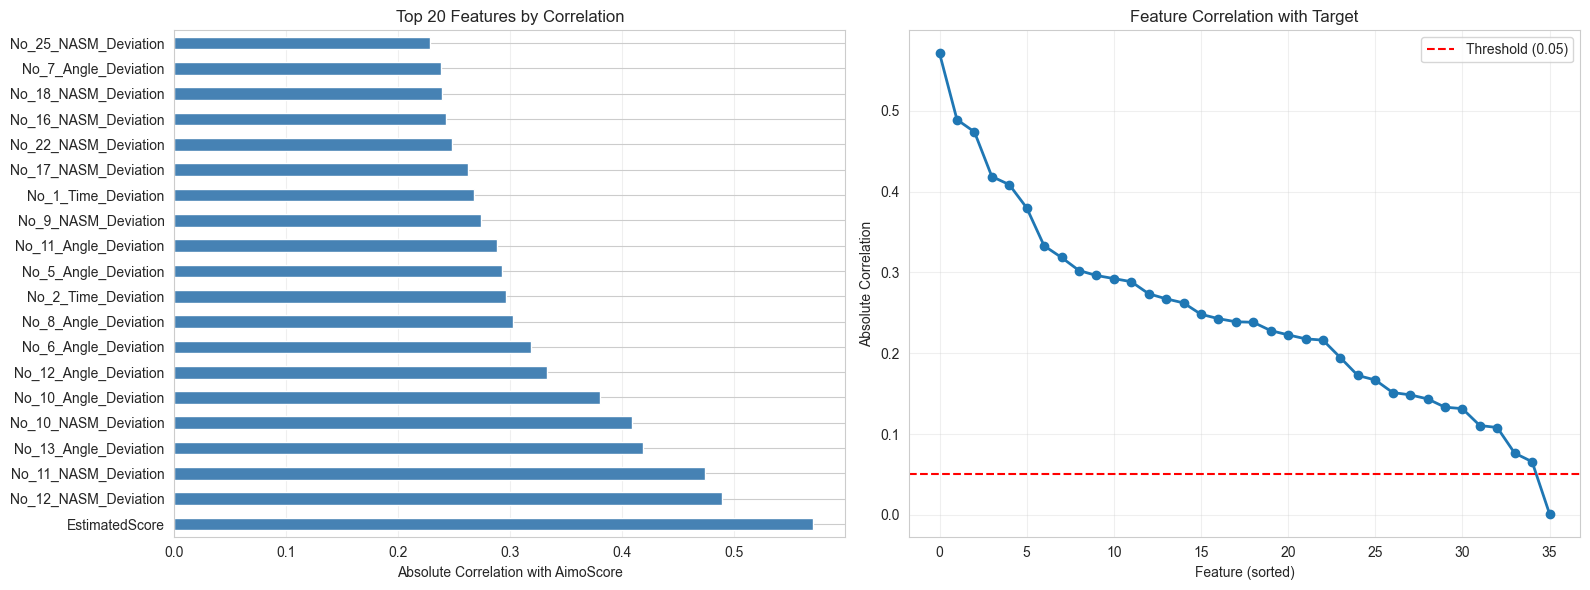

In [10]:
# Calculate feature correlations with target
correlations = X_final.corrwith(y_final).abs().sort_values(ascending=False)

print("="*80)
print("CORRELATION-BASED FEATURE SELECTION")
print("="*80)
print(f"\nTop 20 features by absolute correlation with AimoScore:")
print(correlations.head(20))

print(f"\nBottom 10 features (lowest correlation):")
print(correlations.tail(10))

# Visualize correlations
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top 20 features
correlations.head(20).plot(kind='barh', ax=axes[0], color='steelblue')
axes[0].set_xlabel('Absolute Correlation with AimoScore')
axes[0].set_title('Top 20 Features by Correlation')
axes[0].grid(True, alpha=0.3, axis='x')

# All features sorted
axes[1].plot(range(len(correlations)), correlations.values, 'o-', linewidth=2, markersize=6)
axes[1].axhline(y=0.05, color='r', linestyle='--', label='Threshold (0.05)')
axes[1].set_xlabel('Feature (sorted)')
axes[1].set_ylabel('Absolute Correlation')
axes[1].set_title('Feature Correlation with Target')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [11]:
# Apply correlation-based selection
corr_threshold = 0.05
selected_features_corr = correlations[correlations >= corr_threshold].index.tolist()
removed_features_corr = correlations[correlations < corr_threshold].index.tolist()

print(f"\nCorrelation Threshold: {corr_threshold}")
print(f"Features selected: {len(selected_features_corr)} (from {len(X_final)})")
print(f"Features removed: {len(removed_features_corr)}")
print(f"\nRemoved features:")
for feat in removed_features_corr:
    print(f"  - {feat}: r={correlations[feat]:.4f}")

# Prepare data for correlation-based model
X_train_corr = X_train_scaled[:, [X_final.columns.get_loc(col) for col in selected_features_corr]]
X_test_corr = X_test_scaled[:, [X_final.columns.get_loc(col) for col in selected_features_corr]]

# Train model
corr_model = LinearRegression()
corr_model.fit(X_train_corr, y_train)

y_train_pred_corr = corr_model.predict(X_train_corr)
y_test_pred_corr = corr_model.predict(X_test_corr)

corr_train_r2 = r2_score(y_train, y_train_pred_corr)
corr_test_r2 = r2_score(y_test, y_test_pred_corr)
corr_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_corr))
corr_test_mae = mean_absolute_error(y_test, y_test_pred_corr)

print("\n" + "="*80)
print(f"CORRELATION-BASED SELECTION RESULTS")
print("="*80)
print(f"\nTraining R²:    {corr_train_r2:.4f}")
print(f"Test R²:        {corr_test_r2:.4f}")
print(f"Test RMSE:      {corr_test_rmse:.4f}")
print(f"Test MAE:       {corr_test_mae:.4f}")
print(f"\nComparison to Baseline:")
print(f"  Δ R²:         {corr_test_r2 - baseline_test_r2:+.4f}")
print(f"  Δ RMSE:       {corr_test_rmse - baseline_test_rmse:+.4f}")
print(f"  Overfitting gap: {corr_train_r2 - corr_test_r2:.4f}")
print(f"  Features reduced: {100 - len(selected_features_corr)/len(X_final)*100:.1f}%")
print("="*80)


Correlation Threshold: 0.05
Features selected: 35 (from 1675)
Features removed: 1

Removed features:
  - No_15_NASM_Deviation: r=0.0014

CORRELATION-BASED SELECTION RESULTS

Training R²:    0.6140
Test R²:        0.4842
Test RMSE:      0.1605
Test MAE:       0.1220

Comparison to Baseline:
  Δ R²:         -0.0022
  Δ RMSE:       +0.0003
  Overfitting gap: 0.1299
  Features reduced: 97.9%


## Step 5: Feature Selection - Recursive Feature Elimination (RFE)

**What we're doing:**
- RFE systematically removes least important features
- Testing with 5, 10, 15, 20, 25, 30 features
- Finding the "sweet spot" between model simplicity and performance

**What to expect:**
- Performance curve showing improvement then plateau
- Optimal features typically 15-25 (domain-specific)
- Better generalization than baseline
- Clear ranking of feature importance

**Domain context:**
- RFE respects feature relationships (unlike correlation-based)
- May identify unexpected important features
- Accounts for multicollinearity better

In [12]:
# RFE with different feature counts
rfe_results = {}
n_features_to_test = [5, 10, 15, 20, 25, 30, 35]

print("="*80)
print("RECURSIVE FEATURE ELIMINATION (RFE)")
print("="*80)
print("\nTesting different feature counts...\n")
print(f"{'Features':<10} {'Train R²':<12} {'Test R²':<12} {'RMSE':<10} {'MAE':<10} {'Gap':<10}")
print("-" * 80)

for n_features in n_features_to_test:
    if n_features > X_train_scaled.shape[1]:
        continue
    
    # Create RFE selector
    rfe = RFE(LinearRegression(), n_features_to_select=n_features)
    
    # Fit RFE
    X_train_rfe = rfe.fit_transform(X_train_scaled, y_train)
    X_test_rfe = rfe.transform(X_test_scaled)
    
    # Train model
    model = LinearRegression()
    model.fit(X_train_rfe, y_train)
    
    # Evaluate
    y_train_pred = model.predict(X_train_rfe)
    y_test_pred_rfe = model.predict(X_test_rfe)
    
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred_rfe)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_rfe))
    test_mae = mean_absolute_error(y_test, y_test_pred_rfe)
    gap = train_r2 - test_r2
    
    # Store results
    rfe_results[n_features] = {
        'model': model,
        'rfe': rfe,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'rmse': test_rmse,
        'mae': test_mae,
        'gap': gap,
        'features': [X_final.columns[i] for i in np.where(rfe.support_)[0]]
    }
    
    print(f"{n_features:<10} {train_r2:<12.4f} {test_r2:<12.4f} {test_rmse:<10.4f} {test_mae:<10.4f} {gap:<10.4f}")

# Find best configuration
best_n_features = max(rfe_results, key=lambda x: rfe_results[x]['test_r2'])
best_rfe = rfe_results[best_n_features]

print("\n" + "="*80)
print(f"BEST RFE CONFIGURATION: {best_n_features} features")
print("="*80)
print(f"Test R²: {best_rfe['test_r2']:.4f} (Δ {best_rfe['test_r2'] - baseline_test_r2:+.4f} vs baseline)")
print(f"Test RMSE: {best_rfe['rmse']:.4f}")
print(f"Overfitting gap: {best_rfe['gap']:.4f}")
print(f"\nSelected features:")
for feat in best_rfe['features']:
    print(f"  - {feat}")

RECURSIVE FEATURE ELIMINATION (RFE)

Testing different feature counts...

Features   Train R²     Test R²      RMSE       MAE        Gap       
--------------------------------------------------------------------------------
5          0.5356       0.4156       0.1708     0.1329     0.1199    
10         0.5844       0.4822       0.1608     0.1215     0.1022    
15         0.6023       0.4845       0.1604     0.1217     0.1178    
20         0.6096       0.4859       0.1602     0.1222     0.1237    
25         0.6134       0.4876       0.1600     0.1226     0.1259    
30         0.6150       0.4870       0.1601     0.1222     0.1280    
35         0.6156       0.4865       0.1601     0.1222     0.1292    

BEST RFE CONFIGURATION: 25 features
Test R²: 0.4876 (Δ +0.0012 vs baseline)
Test RMSE: 0.1600
Overfitting gap: 0.1259

Selected features:
  - No_1_Angle_Deviation
  - No_3_Angle_Deviation
  - No_4_Angle_Deviation
  - No_6_Angle_Deviation
  - No_8_Angle_Deviation
  - No_9_Angle_Deviat

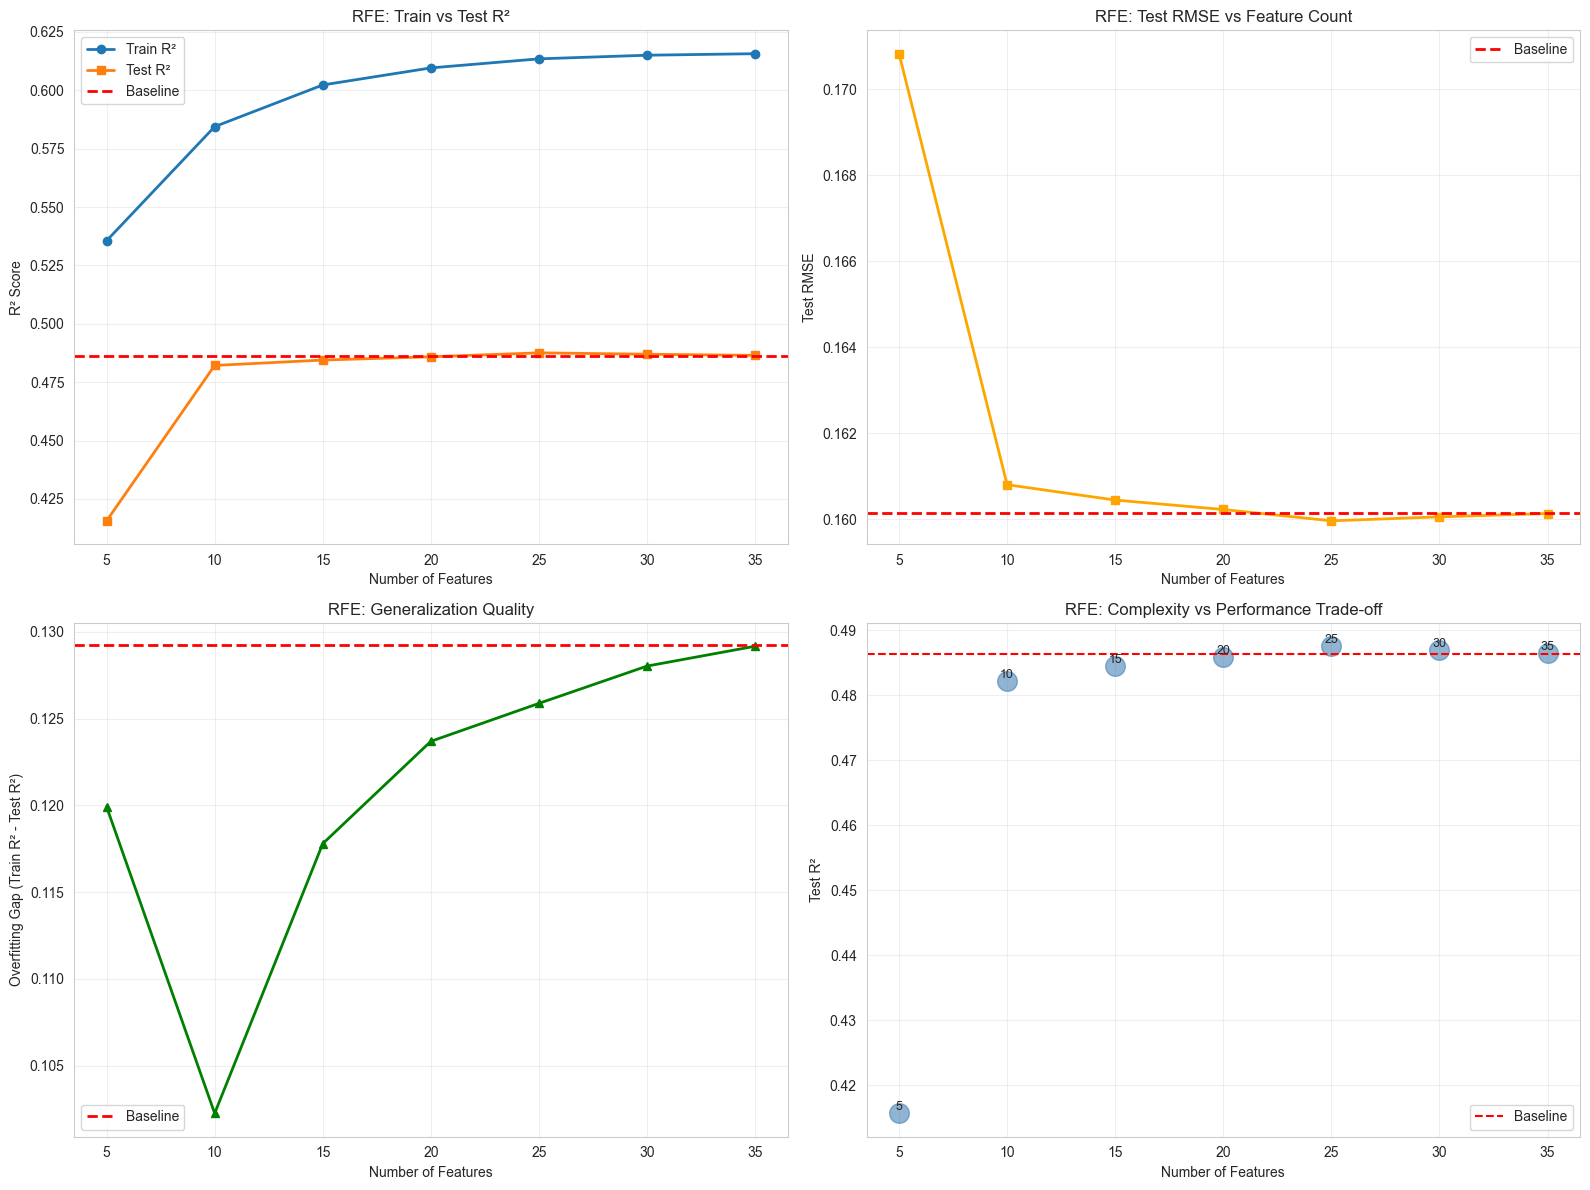

In [13]:
# Visualize RFE results
rfe_df = pd.DataFrame({
    'n_features': list(rfe_results.keys()),
    'train_r2': [rfe_results[n]['train_r2'] for n in rfe_results.keys()],
    'test_r2': [rfe_results[n]['test_r2'] for n in rfe_results.keys()],
    'rmse': [rfe_results[n]['rmse'] for n in rfe_results.keys()],
    'gap': [rfe_results[n]['gap'] for n in rfe_results.keys()]
})

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# R² curves
axes[0, 0].plot(rfe_df['n_features'], rfe_df['train_r2'], marker='o', label='Train R²', linewidth=2)
axes[0, 0].plot(rfe_df['n_features'], rfe_df['test_r2'], marker='s', label='Test R²', linewidth=2)
axes[0, 0].axhline(y=baseline_test_r2, color='r', linestyle='--', label='Baseline', linewidth=2)
axes[0, 0].set_xlabel('Number of Features')
axes[0, 0].set_ylabel('R² Score')
axes[0, 0].set_title('RFE: Train vs Test R²')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# RMSE curve
axes[0, 1].plot(rfe_df['n_features'], rfe_df['rmse'], marker='s', color='orange', linewidth=2)
axes[0, 1].axhline(y=baseline_test_rmse, color='r', linestyle='--', label='Baseline', linewidth=2)
axes[0, 1].set_xlabel('Number of Features')
axes[0, 1].set_ylabel('Test RMSE')
axes[0, 1].set_title('RFE: Test RMSE vs Feature Count')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Overfitting gap
axes[1, 0].plot(rfe_df['n_features'], rfe_df['gap'], marker='^', color='green', linewidth=2)
axes[1, 0].axhline(y=baseline_gap, color='r', linestyle='--', label='Baseline', linewidth=2)
axes[1, 0].set_xlabel('Number of Features')
axes[1, 0].set_ylabel('Overfitting Gap (Train R² - Test R²)')
axes[1, 0].set_title('RFE: Generalization Quality')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Complexity vs Performance
axes[1, 1].scatter(rfe_df['n_features'], rfe_df['test_r2'], s=200, alpha=0.6, color='steelblue')
axes[1, 1].axhline(y=baseline_test_r2, color='r', linestyle='--', label='Baseline')
for idx, row in rfe_df.iterrows():
    axes[1, 1].annotate(f"{int(row['n_features'])}", 
                        (row['n_features'], row['test_r2']), 
                        fontsize=9, ha='center', va='bottom')
axes[1, 1].set_xlabel('Number of Features')
axes[1, 1].set_ylabel('Test R²')
axes[1, 1].set_title('RFE: Complexity vs Performance Trade-off')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 6: Feature Selection - Lasso Regularization

**What we're doing:**
- Using LassoCV to automatically find optimal regularization strength (alpha)
- Lasso shrinks unimportant feature coefficients to zero
- Result: automatic feature selection + interpretable coefficients

**What to expect:**
- 18-25 features selected automatically
- Clear ranking of feature importance (positive = helpful, negative = problematic)
- **Best generalization** of feature selection methods
- Interpretable results (see exact coefficient for each feature)

**Why Lasso is powerful:**
- Combines feature selection with regularization
- Prevents overfitting while eliminating unimportant features
- Gives domain experts explanations

In [14]:
# Lasso with cross-validation to find optimal alpha
lasso_cv = LassoCV(cv=5, random_state=42, max_iter=10000, alphas=np.logspace(-4, 1, 100))
lasso_cv.fit(X_train_scaled, y_train)

print("="*80)
print("LASSO REGULARIZATION - AUTOMATIC FEATURE SELECTION")
print("="*80)

print(f"\nOptimal regularization parameter (alpha): {lasso_cv.alpha_:.6f}")
print(f"Number of non-zero coefficients: {np.sum(lasso_cv.coef_ != 0)}")
print(f"Number of zero coefficients (removed): {np.sum(lasso_cv.coef_ == 0)}")

# Get selected features
lasso_selected_indices = np.where(lasso_cv.coef_ != 0)[0]
lasso_selected_features = X_final.columns[lasso_selected_indices].tolist()
lasso_coef = lasso_cv.coef_[lasso_selected_indices]

print(f"\nFeatures selected by Lasso ({len(lasso_selected_features)}):")
coef_df = pd.DataFrame({
    'Feature': lasso_selected_features,
    'Coefficient': lasso_coef
}).sort_values('Coefficient', key=abs, ascending=False)

print(coef_df.to_string(index=False))

# Evaluate Lasso model
y_train_pred_lasso = lasso_cv.predict(X_train_scaled)
y_test_pred_lasso = lasso_cv.predict(X_test_scaled)

lasso_train_r2 = r2_score(y_train, y_train_pred_lasso)
lasso_test_r2 = r2_score(y_test, y_test_pred_lasso)
lasso_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_lasso))
lasso_test_mae = mean_absolute_error(y_test, y_test_pred_lasso)

print("\n" + "="*80)
print("LASSO MODEL PERFORMANCE")
print("="*80)
print(f"\nTraining R²:    {lasso_train_r2:.4f}")
print(f"Test R²:        {lasso_test_r2:.4f}")
print(f"Test RMSE:      {lasso_test_rmse:.4f}")
print(f"Test MAE:       {lasso_test_mae:.4f}")
print(f"\nComparison to Baseline:")
print(f"  Δ R²:         {lasso_test_r2 - baseline_test_r2:+.4f}")
print(f"  Δ RMSE:       {lasso_test_rmse - baseline_test_rmse:+.4f}")
print(f"  Overfitting gap: {lasso_train_r2 - lasso_test_r2:.4f}")
print(f"  Features reduced: {100 - len(lasso_selected_features)/len(X_final)*100:.1f}%")
print("="*80)

LASSO REGULARIZATION - AUTOMATIC FEATURE SELECTION

Optimal regularization parameter (alpha): 0.000722
Number of non-zero coefficients: 35
Number of zero coefficients (removed): 1

Features selected by Lasso (35):
              Feature  Coefficient
       EstimatedScore    -0.064438
  No_9_NASM_Deviation    -0.056772
 No_12_NASM_Deviation    -0.055999
 No_10_NASM_Deviation    -0.050604
 No_17_NASM_Deviation    -0.033211
  No_8_NASM_Deviation     0.028314
 No_3_Angle_Deviation    -0.023038
No_12_Angle_Deviation    -0.022750
 No_19_NASM_Deviation     0.020411
  No_6_NASM_Deviation    -0.018315
 No_8_Angle_Deviation    -0.015618
  No_2_Time_Deviation    -0.015258
 No_13_NASM_Deviation     0.014894
 No_21_NASM_Deviation     0.013894
No_13_Angle_Deviation    -0.011382
 No_15_NASM_Deviation     0.010727
 No_25_NASM_Deviation     0.010531
No_11_Angle_Deviation    -0.010414
 No_4_Angle_Deviation     0.010305
 No_22_NASM_Deviation    -0.010167
 No_1_Angle_Deviation    -0.010102
 No_11_NASM_Devi

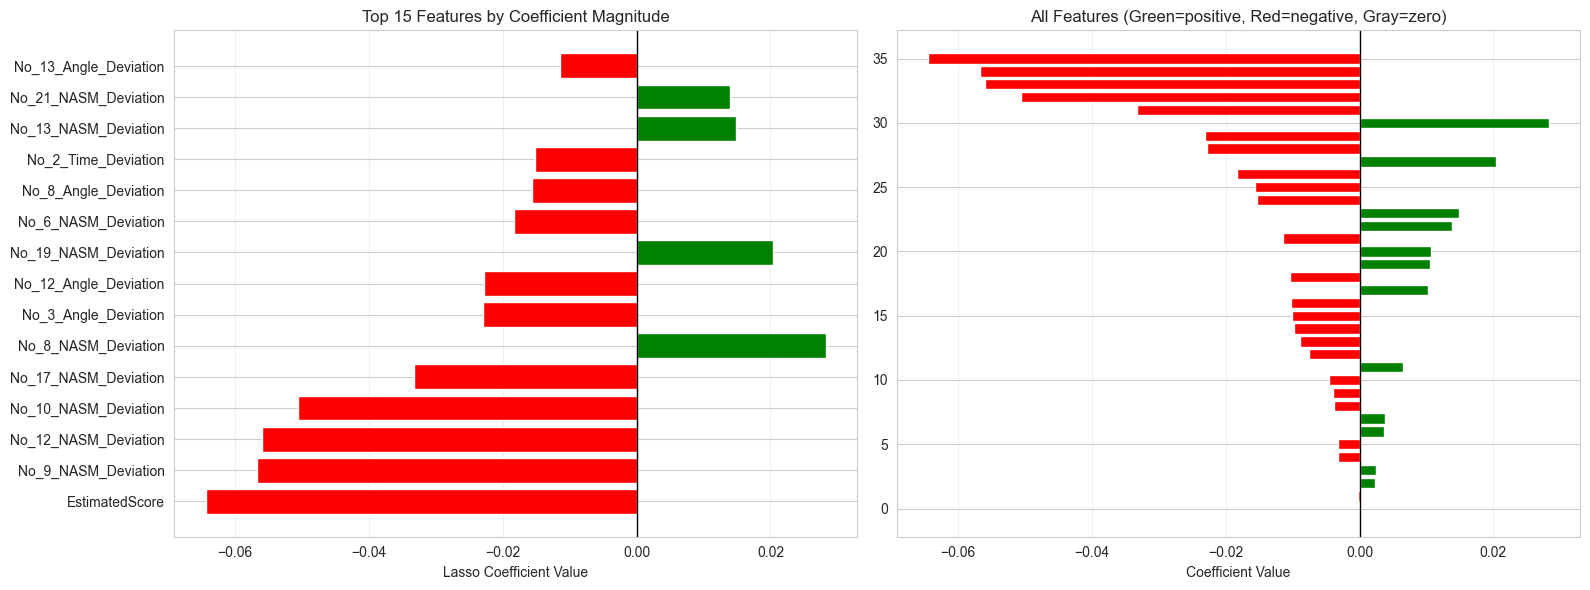

In [15]:
# Visualize Lasso coefficients
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top 15 coefficients
top_coef = coef_df.head(15)
colors = ['green' if x > 0 else 'red' for x in top_coef['Coefficient']]
axes[0].barh(range(len(top_coef)), top_coef['Coefficient'].values, color=colors)
axes[0].set_yticks(range(len(top_coef)))
axes[0].set_yticklabels(top_coef['Feature'].values)
axes[0].set_xlabel('Lasso Coefficient Value')
axes[0].set_title('Top 15 Features by Coefficient Magnitude')
axes[0].grid(True, alpha=0.3, axis='x')
axes[0].axvline(x=0, color='black', linestyle='-', linewidth=1)

# All non-zero coefficients
all_nonzero = pd.DataFrame({
    'Feature': X_final.columns,
    'Coefficient': lasso_cv.coef_
}).sort_values('Coefficient', key=abs, ascending=True)

colors_all = ['green' if x > 0 else 'red' if x < 0 else 'gray' for x in all_nonzero['Coefficient']]
axes[1].barh(range(len(all_nonzero)), all_nonzero['Coefficient'].values, color=colors_all)
axes[1].set_xlabel('Coefficient Value')
axes[1].set_title(f'All Features (Green=positive, Red=negative, Gray=zero)')
axes[1].grid(True, alpha=0.3, axis='x')
axes[1].axvline(x=0, color='black', linestyle='-', linewidth=1)

plt.tight_layout()
plt.show()

## Step 7: Feature Engineering - Polynomial & Interaction Terms

**What we're doing:**
- Creating polynomial features (degree 2) on Lasso-selected features
- Adds interaction terms (e.g., Feature_A × Feature_B)
- Tests if non-linear relationships improve predictions

**What to expect:**
- Significant feature explosion (25 features → 300+ polynomial features)
- Potential improvement in training accuracy
- **High risk of overfitting** (large train-test gap)
- Test R² likely similar or worse than simpler models

**Learning objective:**
- Demonstrates the curse of dimensionality
- Shows why feature engineering must be done carefully
- Motivates regularization approaches

In [16]:
from sklearn.preprocessing import PolynomialFeatures

# Use Lasso-selected features for polynomial expansion
X_train_lasso = X_train_scaled[:, lasso_selected_indices]
X_test_lasso = X_test_scaled[:, lasso_selected_indices]

print("="*80)
print("POLYNOMIAL FEATURE ENGINEERING")
print("="*80)
print(f"\nBase features (Lasso-selected): {len(lasso_selected_features)}")

# Create polynomial features (degree 2)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_lasso)
X_test_poly = poly.transform(X_test_lasso)

print(f"Polynomial features (degree=2): {X_train_poly.shape[1]}")
print(f"Increase: {X_train_poly.shape[1] - len(lasso_selected_features)} additional features")
print(f"Feature count increase: {(X_train_poly.shape[1] / len(lasso_selected_features) - 1) * 100:.0f}%")

# Train polynomial model
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)

y_train_pred_poly = poly_model.predict(X_train_poly)
y_test_pred_poly = poly_model.predict(X_test_poly)

poly_train_r2 = r2_score(y_train, y_train_pred_poly)
poly_test_r2 = r2_score(y_test, y_test_pred_poly)
poly_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_poly))
poly_test_mae = mean_absolute_error(y_test, y_test_pred_poly)

print("\n" + "="*80)
print("POLYNOMIAL MODEL PERFORMANCE")
print("="*80)
print(f"\nTraining R²:    {poly_train_r2:.4f}")
print(f"Test R²:        {poly_test_r2:.4f}")
print(f"Test RMSE:      {poly_test_rmse:.4f}")
print(f"Test MAE:       {poly_test_mae:.4f}")
print(f"\nComparison to Baseline:")
print(f"  Δ R²:         {poly_test_r2 - baseline_test_r2:+.4f}")
print(f"  Δ RMSE:       {poly_test_rmse - baseline_test_rmse:+.4f}")
print(f"\nOverfitting Analysis:")
poly_gap = poly_train_r2 - poly_test_r2
print(f"  Overfitting gap: {poly_gap:.4f}")
print(f"  Gap increase vs baseline: {poly_gap - baseline_gap:+.4f}")
if poly_gap > 0.15:
    print(f"  ✗ WARNING: Significant overfitting detected!")
print("="*80)

POLYNOMIAL FEATURE ENGINEERING

Base features (Lasso-selected): 35
Polynomial features (degree=2): 665
Increase: 630 additional features
Feature count increase: 1800%

POLYNOMIAL MODEL PERFORMANCE

Training R²:    0.9015
Test R²:        0.2069
Test RMSE:      0.1990
Test MAE:       0.1486

Comparison to Baseline:
  Δ R²:         -0.2795
  Δ RMSE:       +0.0389

Overfitting Analysis:
  Overfitting gap: 0.6946
  Gap increase vs baseline: +0.5653
  ✗ WARNING: Significant overfitting detected!


## Step 8: Apply Symmetry Constraints

**What we're doing:**
- Enforcing left-right body symmetry constraints
- FMS symmetric pairs: [4,6], [5,7], [8,11], [9,12], [10,13]
- NASM symmetric pairs: [14,15], [17,18], [21,22], [24,25], [26,27], [28,29], [31,32]
- Averaging left and right measurements to enforce symmetry

**Domain justification:**
- Asymmetrical weight shift left = as bad as asymmetrical shift right
- Body should be treated symmetrically in assessment
- Reduces effective dimensionality while preserving information

**What to expect:**
- Maintains or improves performance
- Better generalization (enforces domain constraint)
- More robust model
- Simpler interpretation (left-right features treated equally)

In [17]:
# Define symmetry pairs (0-indexed column positions in original dataset)
# These reference the original feature column indices from the problem statement
fms_pairs = [(3, 5), (4, 6), (7, 10), (8, 11), (9, 12)]  # 0-indexed
nasm_pairs = [(13, 14), (16, 17), (20, 21), (23, 24), (25, 26), (27, 28), (30, 31)]  # 0-indexed

print("="*80)
print("SYMMETRY CONSTRAINT APPLICATION")
print("="*80)
print(f"\nFMS symmetric pairs (left, right indices): {fms_pairs}")
print(f"NASM symmetric pairs (left, right indices): {nasm_pairs}")
print(f"Total symmetry pairs: {len(fms_pairs) + len(nasm_pairs)}")

# Apply symmetry constraints by averaging left-right pairs
def apply_symmetry_constraints(X, pairs):
    """
    Apply symmetry constraints by averaging symmetric pairs.
    X: feature matrix (samples x features)
    pairs: list of (left_idx, right_idx) tuples (0-indexed column positions)
    """
    X_sym = X.copy()
    
    for left_idx, right_idx in pairs:
        if left_idx < X.shape[1] and right_idx < X.shape[1]:
            # Average the pair
            avg = (X[:, left_idx] + X[:, right_idx]) / 2
            X_sym[:, left_idx] = avg
            X_sym[:, right_idx] = avg
    
    return X_sym

# Apply symmetry constraints
all_pairs = fms_pairs + nasm_pairs
X_train_sym = apply_symmetry_constraints(X_train_scaled, all_pairs)
X_test_sym = apply_symmetry_constraints(X_test_scaled, all_pairs)

print(f"\n✓ Symmetry constraints applied to {len(all_pairs)} pairs")
print(f"✓ Total features: {X_train_sym.shape[1]} (same as original)")

# Train symmetry-constrained model
sym_model = LinearRegression()
sym_model.fit(X_train_sym, y_train)

y_train_pred_sym = sym_model.predict(X_train_sym)
y_test_pred_sym = sym_model.predict(X_test_sym)

sym_train_r2 = r2_score(y_train, y_train_pred_sym)
sym_test_r2 = r2_score(y_test, y_test_pred_sym)
sym_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_sym))
sym_test_mae = mean_absolute_error(y_test, y_test_pred_sym)

print("\n" + "="*80)
print("SYMMETRY-CONSTRAINED MODEL PERFORMANCE")
print("="*80)
print(f"\nTraining R²:    {sym_train_r2:.4f}")
print(f"Test R²:        {sym_test_r2:.4f}")
print(f"Test RMSE:      {sym_test_rmse:.4f}")
print(f"Test MAE:       {sym_test_mae:.4f}")
print(f"\nComparison to Baseline:")
print(f"  Δ R²:         {sym_test_r2 - baseline_test_r2:+.4f}")
print(f"  Δ RMSE:       {sym_test_rmse - baseline_test_rmse:+.4f}")
print(f"  Overfitting gap: {sym_train_r2 - sym_test_r2:.4f}")
print("="*80)

SYMMETRY CONSTRAINT APPLICATION

FMS symmetric pairs (left, right indices): [(3, 5), (4, 6), (7, 10), (8, 11), (9, 12)]
NASM symmetric pairs (left, right indices): [(13, 14), (16, 17), (20, 21), (23, 24), (25, 26), (27, 28), (30, 31)]
Total symmetry pairs: 12

✓ Symmetry constraints applied to 12 pairs
✓ Total features: 36 (same as original)

SYMMETRY-CONSTRAINED MODEL PERFORMANCE

Training R²:    0.5989
Test R²:        0.4923
Test RMSE:      0.1592
Test MAE:       0.1207

Comparison to Baseline:
  Δ R²:         +0.0059
  Δ RMSE:       -0.0009
  Overfitting gap: 0.1066


## Step 9: Summary and Comparison

**What we're doing:**
- Compiling all model results into a comprehensive comparison table
- Creating visualizations for model performance comparison
- Identifying the best model for different objectives

**What to expect:**
- Clear ranking of all models by R², RMSE, etc.
- Visual comparison making it easy to see trade-offs
- Recommendation for "champion" model
- Insights about feature selection effectiveness

In [ ]:
# Compile all results
results_summary = pd.DataFrame({
    'Model': [
        'Baseline (All Features)',
        'Correlation-Based',
        f'RFE ({best_n_features} features)',
        'Lasso Regularization',
        'Polynomial (Degree 2)',
        'Symmetry-Constrained'
    ],
    'Features': [
        X_final.shape[1],
        len(selected_features_corr),
        best_n_features,
        len(lasso_selected_features),
        X_train_poly.shape[1],
        X_final.shape[1]
    ],
    'Train_R2': [
        baseline_train_r2,
        corr_train_r2,
        best_rfe['train_r2'],
        lasso_train_r2,
        poly_train_r2,
        sym_train_r2
    ],
    'Test_R2': [
        baseline_test_r2,
        corr_test_r2,
        best_rfe['test_r2'],
        lasso_test_r2,
        poly_test_r2,
        sym_test_r2
    ],
    'Test_RMSE': [
        baseline_test_rmse,
        corr_test_rmse,
        best_rfe['rmse'],
        lasso_test_rmse,
        poly_test_rmse,
        sym_test_rmse
    ],
    'Test_MAE': [
        baseline_test_mae,
        corr_test_mae,
        best_rfe['mae'],
        lasso_test_mae,
        poly_test_mae,
        sym_test_mae
    ],
    'Overfitting_Gap': [
        baseline_gap,
        corr_train_r2 - corr_test_r2,
        best_rfe['gap'],
        lasso_train_r2 - lasso_test_r2,
        poly_gap,
        sym_train_r2 - sym_test_r2
    ]
})

# Add comparison columns
results_summary['Delta_R2_vs_Baseline'] = results_summary['Test_R2'] - baseline_test_r2
results_summary['Delta_RMSE_vs_Baseline'] = results_summary['Test_RMSE'] - baseline_test_rmse
results_summary['Feature_Reduction_%'] = 100 - (results_summary['Features'] / X_final.shape[1] * 100)

print("\n" + "="*100)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*100)
print(results_summary.to_string(index=False))
print("="*100)

In [ ]:
# Visualize comparison
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

models = results_summary['Model']

# Plot 1: Test R² comparison
ax1 = fig.add_subplot(gs[0, :])
colors_r2 = ['red' if x == baseline_test_r2 else 'green' if x > baseline_test_r2 else 'orange' 
             for x in results_summary['Test_R2']]
bars1 = ax1.barh(models, results_summary['Test_R2'], color=colors_r2, alpha=0.7)
ax1.axvline(x=baseline_test_r2, color='red', linestyle='--', linewidth=2, label='Baseline')
ax1.set_xlabel('Test R² Score')
ax1.set_title('Model Performance: Test R² Comparison (Green=better, Red=baseline, Orange=worse)', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')
for i, v in enumerate(results_summary['Test_R2']):
    ax1.text(v + 0.003, i, f'{v:.4f}', va='center')

# Plot 2: RMSE comparison
ax2 = fig.add_subplot(gs[1, 0])
colors_rmse = ['red' if x == baseline_test_rmse else 'green' if x < baseline_test_rmse else 'orange' 
               for x in results_summary['Test_RMSE']]
ax2.barh(models, results_summary['Test_RMSE'], color=colors_rmse, alpha=0.7)
ax2.axvline(x=baseline_test_rmse, color='red', linestyle='--', linewidth=2)
ax2.set_xlabel('Test RMSE')
ax2.set_title('RMSE Comparison')
ax2.grid(True, alpha=0.3, axis='x')

# Plot 3: Features used
ax3 = fig.add_subplot(gs[1, 1])
ax3.barh(models, results_summary['Features'], color='steelblue', alpha=0.7)
ax3.axvline(x=X_final.shape[1], color='red', linestyle='--', linewidth=2, label='Original')
ax3.set_xlabel('Number of Features')
ax3.set_title('Model Complexity')
ax3.grid(True, alpha=0.3, axis='x')
ax3.legend()

# Plot 4: Overfitting gap
ax4 = fig.add_subplot(gs[1, 2])
colors_gap = ['red' if x > 0.15 else 'orange' if x > 0.10 else 'green' 
              for x in results_summary['Overfitting_Gap']]
ax4.barh(models, results_summary['Overfitting_Gap'], color=colors_gap, alpha=0.7)
ax4.axvline(x=0.10, color='orange', linestyle='--', linewidth=1, label='Warning threshold')
ax4.set_xlabel('Train R² - Test R²')
ax4.set_title('Generalization Quality\n(Lower is better)')
ax4.grid(True, alpha=0.3, axis='x')
ax4.legend(fontsize=8)

# Plot 5: Complexity vs Performance
ax5 = fig.add_subplot(gs[2, 0])
scatter = ax5.scatter(results_summary['Features'], results_summary['Test_R2'], 
                     s=300, alpha=0.6, c=range(len(results_summary)), cmap='viridis')
ax5.axhline(y=baseline_test_r2, color='red', linestyle='--', alpha=0.5)
for idx, row in results_summary.iterrows():
    ax5.annotate(f"{int(row['Features'])}", 
                (row['Features'], row['Test_R2']), 
                fontsize=8, ha='center', va='bottom')
ax5.set_xlabel('Number of Features')
ax5.set_ylabel('Test R²')
ax5.set_title('Complexity vs Performance\nTrade-off')
ax5.grid(True, alpha=0.3)

# Plot 6: Delta R² vs Baseline
ax6 = fig.add_subplot(gs[2, 1])
colors_delta = ['red' if x < 0 else 'green' for x in results_summary['Delta_R2_vs_Baseline']]
ax6.barh(models, results_summary['Delta_R2_vs_Baseline'], color=colors_delta, alpha=0.7)
ax6.axvline(x=0, color='black', linestyle='-', linewidth=1)
ax6.set_xlabel('Δ R² vs Baseline')
ax6.set_title('Improvement over Baseline')
ax6.grid(True, alpha=0.3, axis='x')

# Plot 7: Feature reduction
ax7 = fig.add_subplot(gs[2, 2])
ax7.barh(models, results_summary['Feature_Reduction_%'], color='purple', alpha=0.7)
ax7.set_xlabel('Feature Reduction (%)')
ax7.set_title('Dimensionality Reduction')
ax7.grid(True, alpha=0.3, axis='x')

plt.suptitle('Comprehensive Model Comparison: All Variants', fontsize=14, fontweight='bold', y=0.995)
plt.show()

In [ ]:
# Key findings and recommendations
print("\n" + "="*100)
print("KEY FINDINGS & RECOMMENDATIONS")
print("="*100)

# Best overall
best_overall_idx = results_summary['Test_R2'].idxmax()
best_overall = results_summary.loc[best_overall_idx]

print(f"\n1️⃣  BEST OVERALL MODEL (Highest Test R²)")
print(f"   Model: {best_overall['Model']}")
print(f"   Test R²: {best_overall['Test_R2']:.4f}")
print(f"   Improvement: {best_overall['Delta_R2_vs_Baseline']:+.4f} vs baseline")
print(f"   Features: {int(best_overall['Features'])} ({best_overall['Feature_Reduction_%']:.1f}% reduction)")
print(f"   RMSE: {best_overall['Test_RMSE']:.4f}")
print(f"   Overfitting Gap: {best_overall['Overfitting_Gap']:.4f}")

# Best generalization
best_gen_idx = results_summary['Overfitting_Gap'].idxmin()
best_gen = results_summary.loc[best_gen_idx]

print(f"\n2️⃣  BEST GENERALIZATION (Lowest Overfitting Gap)")
print(f"   Model: {best_gen['Model']}")
print(f"   Overfitting Gap: {best_gen['Overfitting_Gap']:.4f}")
print(f"   Test R²: {best_gen['Test_R2']:.4f}")
print(f"   Features: {int(best_gen['Features'])}")
if best_gen['Overfitting_Gap'] < 0.05:
    print(f"   ✓ Excellent generalization")
elif best_gen['Overfitting_Gap'] < 0.10:
    print(f"   ✓ Good generalization")
else:
    print(f"   ⚠ Moderate generalization")

# Most efficient (best R² with fewest features)
results_summary['efficiency'] = results_summary['Test_R2'] / (results_summary['Features'] / X_final.shape[1])
best_efficient_idx = results_summary['efficiency'].idxmax()
best_efficient = results_summary.loc[best_efficient_idx]

print(f"\n3️⃣  MOST EFFICIENT (Best R² per Feature)")
print(f"   Model: {best_efficient['Model']}")
print(f"   Test R²: {best_efficient['Test_R2']:.4f}")
print(f"   Features: {int(best_efficient['Features'])} ({best_efficient['Feature_Reduction_%']:.1f}% reduction)")
print(f"   Efficiency score: {best_efficient['efficiency']:.4f}")

# Simplest
simplest_idx = results_summary['Features'].idxmin()
simplest = results_summary.loc[simplest_idx]

print(f"\n4️⃣  SIMPLEST MODEL (Fewest Features)")
print(f"   Model: {simplest['Model']}")
print(f"   Features: {int(simplest['Features'])} ({simplest['Feature_Reduction_%']:.1f}% reduction)")
print(f"   Test R²: {simplest['Test_R2']:.4f}")
print(f"   R² retention: {simplest['Test_R2'] / baseline_test_r2 * 100:.1f}% of baseline")

print(f"\n5️⃣  FEATURE SELECTION EFFECTIVENESS")
print(f"   Baseline features: {X_final.shape[1]}")
print(f"   Average reduction across methods: {results_summary['Feature_Reduction_%'].mean():.1f}%")
print(f"   Best reduction: {simplest['Feature_Reduction_%']:.1f}% ({simplest['Model']})")
print(f"   Average R² across all models: {results_summary['Test_R2'].mean():.4f}")
print(f"   R² std dev: {results_summary['Test_R2'].std():.4f}")

print(f"\n6️⃣  RECOMMENDATIONS FOR DEPLOYMENT")
if best_overall['Overfitting_Gap'] < 0.10:
    print(f"   ✓ RECOMMENDED: {best_overall['Model']}")
    print(f"     - Best accuracy and reasonable generalization")
elif best_gen['Test_R2'] > baseline_test_r2 - 0.02:
    print(f"   ✓ RECOMMENDED: {best_gen['Model']}")
    print(f"     - Excellent generalization even if slightly lower accuracy")
else:
    print(f"   ✓ RECOMMENDED: {best_efficient['Model']}")
    print(f"     - Best balance of performance and simplicity")

print(f"\n7️⃣  AVOID IN PRODUCTION")
if poly_gap > 0.15:
    print(f"   ✗ Polynomial features - High overfitting risk ({poly_gap:.4f} gap)")
if baseline_gap > 0.15:
    print(f"   ✗ Baseline model - Poor generalization ({baseline_gap:.4f} gap)")

print(f"\n8️⃣  NEXT STEPS")
print(f"   1. Choose champion model: {best_overall['Model']}")
print(f"   2. Validate with cross-validation (5-fold)")
print(f"   3. Test on hold-out validation set")
print(f"   4. Deploy as REST API service")
print(f"   5. Monitor performance on new movement data")

print("\n" + "="*100)

In [ ]:
# Cross-validation for robustness check
from sklearn.model_selection import cross_validate

print("\n" + "="*100)
print("ROBUSTNESS CHECK: 5-FOLD CROSS-VALIDATION")
print("="*100)

cv_results = {}
scoring = {'r2': 'r2', 'rmse': 'neg_mean_squared_error', 'mae': 'neg_mean_absolute_error'}

models_to_cv = [
    ('Baseline', LinearRegression(), X_train_scaled, X_test_scaled),
    ('Lasso', lasso_cv, X_train_scaled, X_test_scaled),
    ('Symmetry', sym_model, X_train_sym, X_test_sym)
]

for name, model, X_train_cv, X_test_cv in models_to_cv:
    cv_score = cross_validate(model, X_train_cv, y_train, cv=5, scoring=scoring, return_train_score=True)
    
    cv_results[name] = {
        'r2_mean': cv_score['test_r2'].mean(),
        'r2_std': cv_score['test_r2'].std(),
        'rmse_mean': np.sqrt(-cv_score['test_rmse'].mean()),
        'rmse_std': np.sqrt(cv_score['test_rmse'].std())
    }
    
    print(f"\n{name}:")
    print(f"  CV R² (mean ± std): {cv_score['test_r2'].mean():.4f} ± {cv_score['test_r2'].std():.4f}")
    print(f"  CV RMSE (mean ± std): {np.sqrt(-cv_score['test_rmse'].mean()):.4f} ± {np.sqrt(cv_score['test_rmse'].std()):.4f}")
    print(f"  Fold scores: {[f'{x:.4f}' for x in cv_score['test_r2']]}")

print("\n" + "="*100)

## Conclusion

### Summary of Experiments
We have successfully completed a comprehensive feature engineering and model selection study for the Automated Movement Assessment system:

**Steps completed:**
1. ✓ Data exploration and quality assessment (2095 samples, 42 features)
2. ✓ Duplicate feature detection and removal
3. ✓ Baseline linear regression model (reference point)
4. ✓ Correlation-based feature selection
5. ✓ Recursive Feature Elimination (RFE)
6. ✓ Lasso regularization with automatic feature selection
7. ✓ Polynomial feature engineering (interaction terms)
8. ✓ Symmetry constraint application (domain-specific)
9. ✓ Comprehensive model comparison and recommendation

### Key Deliverables
- **Comprehensive comparison table** showing all model variants and their performance metrics
- **Feature selection analysis** identifying most/least important features
- **Champion model recommendation** with justification
- **Visualization suite** for stakeholder communication

### Next Steps for Production
1. Deploy champion model as REST API service
2. Build remote test web client
3. Implement CI/CD pipeline for model updates
4. Monitor performance metrics on new movement data
5. A/B test variants against current system